In [1]:
%matplotlib inline

In [2]:
import os
import netCDF4
import numpy as np
import math
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from geophys_utils import NetCDFGridUtils
from geophys_utils import NetCDFLineUtils
from geophys_utils import get_gdal_wcs_dataset, get_gdal_grid_values
from geophys_utils import get_spatial_ref_from_crs, get_coordinate_transformation, get_utm_crs, transform_coords
from geophys_utils._transect_utils import line_length, point_along_line, utm_coords, coords2distance, sample_transect

In [3]:
# Setup proxy as required
GA_STAFF_WIFI = False

if GA_STAFF_WIFI:
    os.environ['http_proxy'] = 'http://proxy.inno.lan:3128'
    os.environ['https_proxy'] = 'http://proxy.inno.lan:3128'

In [4]:
aem_nc_path = '/g/data2/uc0/rr2_dev/rcb547/AEM_examples/AUS_10008_WestK_LCI.nc'
if not os.path.isfile(aem_nc_path):
    aem_nc_path = 'http://dapds00.nci.org.au/thredds/dodsC/uc0/rr2_dev/rcb547/AEM_examples/AUS_10008_WestK_LCI.nc'

In [5]:
aem_nc_dataset = netCDF4.Dataset(aem_nc_path)

In [6]:
# The CRS definition in the file is INCORRECT! It specifies degrees, not metres.
crs = get_spatial_ref_from_crs(aem_nc_dataset.variables['crs'].epsg_code).ExportToWkt()
crs

'GEOGCS["GDA94",DATUM["Geocentric_Datum_of_Australia_1994",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],TOWGS84[0,0,0,0,0,0,0],AUTHORITY["EPSG","6283"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4283"]]'

In [7]:
# Get the right CRS (even though we don't actually need it)
utm_crs = get_utm_crs((123.4, -18.01), 'EPSG:4326') # Coordinate in area of interest read from Google Earth
utm_crs

'PROJCS["UTM Zone 51, Southern Hemisphere",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],TOWGS84[0,0,0,0,0,0,0],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9108"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",123],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",10000000],UNIT["Meter",1]]'

In [8]:
aem_nc_dataset.variables['line'].shape

(199,)

In [9]:
line_no = 103901 
line_index = np.where(aem_nc_dataset.variables['line'][...] == line_no)[0][0]
line_index

40

In [10]:
line_start = aem_nc_dataset.variables['index_line'][line_index]
point_count = aem_nc_dataset.variables['index_count'][line_index]
line_end = line_start + point_count
line_slice = slice(line_start, line_end)


In [11]:
# Create array of UTM coordinate pairs for all points in selected line
utm_coordinates = np.zeros(shape=(point_count, 2), dtype=aem_nc_dataset.variables['easting'].dtype)
utm_coordinates[:,0] = aem_nc_dataset.variables['easting'][line_slice]
utm_coordinates[:,1] = aem_nc_dataset.variables['northing'][line_slice]
utm_coordinates

array([[  590217.4,  8064180.2],
       [  590227.7,  8064204.8],
       [  590238.2,  8064228.3],
       ..., 
       [  613096.4,  8106423.1],
       [  613109.6,  8106446.8],
       [  613121.9,  8106469.6]])

In [12]:
# Compute cumulative distance along line for each point
distances = coords2distance(utm_coordinates)
distances

array([  0.00000000e+00,   2.66692707e+01,   5.24083461e+01, ...,
         4.84544006e+04,   4.84815287e+04,   4.85074348e+04])

In [13]:
# Obtain top elevation for each layer at each point
layer_top_elevations = aem_nc_dataset.variables['layer_top_elevation'][line_slice]
layer_top_elevations.shape

(1844, 30)

In [14]:
# Obtain conductivity for each layer at each point
layer_conductivities = aem_nc_dataset.variables['layer_conductivity_masked'][line_slice].filled(np.NaN)
layer_conductivities.shape

(1844, 30)

In [15]:
# Not used yet
layer_uncertainties = aem_nc_dataset.variables['layer_uncertainty'][line_slice]
layer_uncertainties.shape

(1844, 30)

In [16]:
# Number of subdivisions for each layer for interpolation. 
# Note that transition between adjacent layer values will occur in lowest subdivision of uppermost layer
layer_subdivisions = 2

In [17]:
# Complete elevation array for layer samples indexed by point and layer
sublayer_elevations = np.ones(shape=(layer_top_elevations.shape[0], layer_top_elevations.shape[1]*layer_subdivisions), 
                          dtype=layer_top_elevations.dtype) * np.NaN

In [18]:
# Complete conductivity array for layer samples indexed by point and layer
sublayer_conductivities = np.ones(shape=(layer_top_elevations.shape[0], layer_top_elevations.shape[1]*layer_subdivisions), 
                                  dtype=layer_conductivities.dtype) * np.NaN

In [19]:
# Array of minimum elevations for each point
min_elevation = np.ones(shape=(layer_top_elevations.shape[0],), 
                        dtype=layer_top_elevations.dtype) * np.NaN

In [20]:
# Sub-sample layers for later interpolation. Remember minimum valid elevation for each point
for point_index in range(layer_top_elevations.shape[0]):
    for layer_index in range(layer_top_elevations.shape[1]):
        try:
            layer_thickness = layer_top_elevations[point_index, layer_index] - layer_top_elevations[point_index, layer_index + 1]
        except:
            break
            
        if np.isnan(layer_conductivities[point_index, layer_index]):
            break
            
        #print layer_top_elevations[point_index, layer_index], layer_thickness, layer_conductivities[point_index, layer_index]
        min_elevation[point_index] = layer_top_elevations[point_index, layer_index + 1]
        
        for sublayer_index in range(layer_subdivisions):
            sublayer_elevations[point_index, layer_index*layer_subdivisions+sublayer_index] = layer_top_elevations[point_index, layer_index] - sublayer_index * layer_thickness / layer_subdivisions 
            sublayer_conductivities[point_index, layer_index*layer_subdivisions+sublayer_index] = layer_conductivities[point_index, layer_index]

In [21]:
# Display max/min elevation values
print np.nanmax(min_elevation)
print np.nanmin(min_elevation)
min_elevation

-97.3
-465.1


array([-122.30000305, -122.19999695, -121.90000153, ..., -169.8999939 ,
       -170.19999695, -170.19999695], dtype=float32)

In [22]:
# Create complete 2D grid of sub-layer point distances for every point/layer - needed for interpolation
point_distances = np.ones(shape=(layer_top_elevations.shape[0], layer_top_elevations.shape[1]*layer_subdivisions), 
                                  dtype=layer_top_elevations.dtype) * np.NaN
for depth_index in range(point_distances.shape[1]):
    point_distances[:,depth_index] = distances
#point_distances

In [23]:
# Obtain good data mask to discard invalid layer samples
good_data_mask = np.logical_and(~np.isnan(sublayer_elevations), ~np.isnan(sublayer_conductivities))
#good_data_mask

In [24]:
# Discard invalid points and store distance/elevation coordinates in dense 2D array
point_distance_elevation = np.ones(shape=(np.count_nonzero(good_data_mask), 2), 
                                  dtype=layer_top_elevations.dtype) * np.NaN
point_distance_elevation[:,0] = point_distances[good_data_mask]
point_distance_elevation[:,1] = sublayer_elevations[good_data_mask]
point_distance_elevation.shape

(88950, 2)

In [25]:
# Discard invalid conductivity points
point_conductivity = sublayer_conductivities[good_data_mask]
point_conductivity

array([   2.96824002,    2.96824002,    3.11525989, ...,  168.32182312,
        197.86308289,  197.86308289], dtype=float32)

In [26]:
# Compute distance range for bitmap
distance_range = (math.floor(min(point_distance_elevation[:,0]) / 10.0) * 10.0, 
                   math.ceil(max(point_distance_elevation[:,0]) / 10.0) * 10.0)
distance_range

(0.0, 48510.0)

In [27]:
# Compute elevation range for bitmap
elevation_range = (math.floor(min(point_distance_elevation[:,1]) / 10.0) * 10.0, 
                   math.ceil(max(point_distance_elevation[:,1]) / 10.0) * 10.0)
elevation_range

(-440.0, 80.0)

In [28]:
# Compute regular grid for resampling
resampling_method = 'linear'

xres = 10.0 # 10m/pixel horizontally
yres = 1.0 # 1m/pixel vertically

grid_y, grid_x = np.mgrid[elevation_range[1]:elevation_range[0]-yres/2.0:-yres, 
                          distance_range[0]:distance_range[1]+xres/2.0:xres]
#print grid_y, grid_x 

In [29]:
# Compute interpolated 1D array of minimum valid elevation values for each X
min_elevation_grid = griddata(point_distances[:,0],
                              min_elevation,
                              grid_x[0], 
                              method=resampling_method)
min_elevation_grid

array([-122.30000305, -122.26250443, -122.2250058 , ..., -170.19999695,
       -170.19999695,           nan])

In [30]:
# Resample point-wise conductivity into regular grid for bitmap
conductivity_grid = griddata(point_distance_elevation[:,::-1],
         point_conductivity,
         (grid_y, grid_x), 
         method=resampling_method)
#conductivity_grid

In [31]:
# Purge interpolated values for all elevations < minimum valid elevation
for x_index in range(conductivity_grid.shape[1]):
    min_elevation_indices = np.where(grid_y[:,x_index] < min_elevation_grid[x_index])[0]
    #print min_elevation_indices
    try:
        conductivity_grid[min_elevation_indices, x_index] = np.NaN
    except:
        pass
    #print conductivity_grid[:, x_index]

In [32]:
# Availabole cmap values for imshow:
# Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag, flag_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, gi

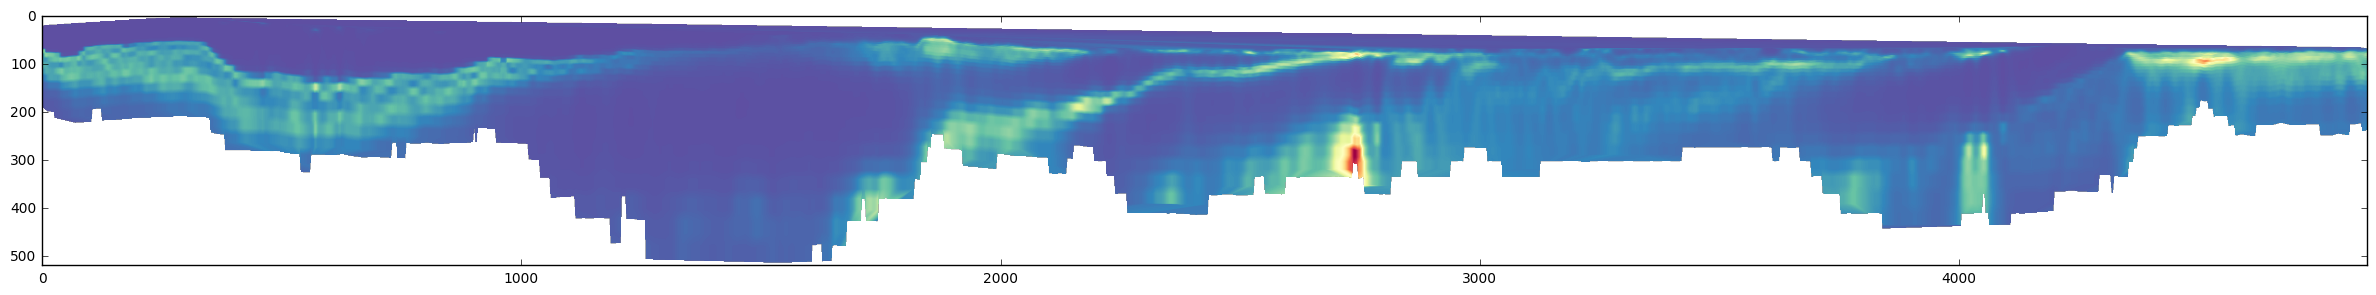

In [33]:
# Plot linear colour stretch
plt.figure(figsize=(30,20))    
plt.imshow(conductivity_grid, cmap='Spectral_r')

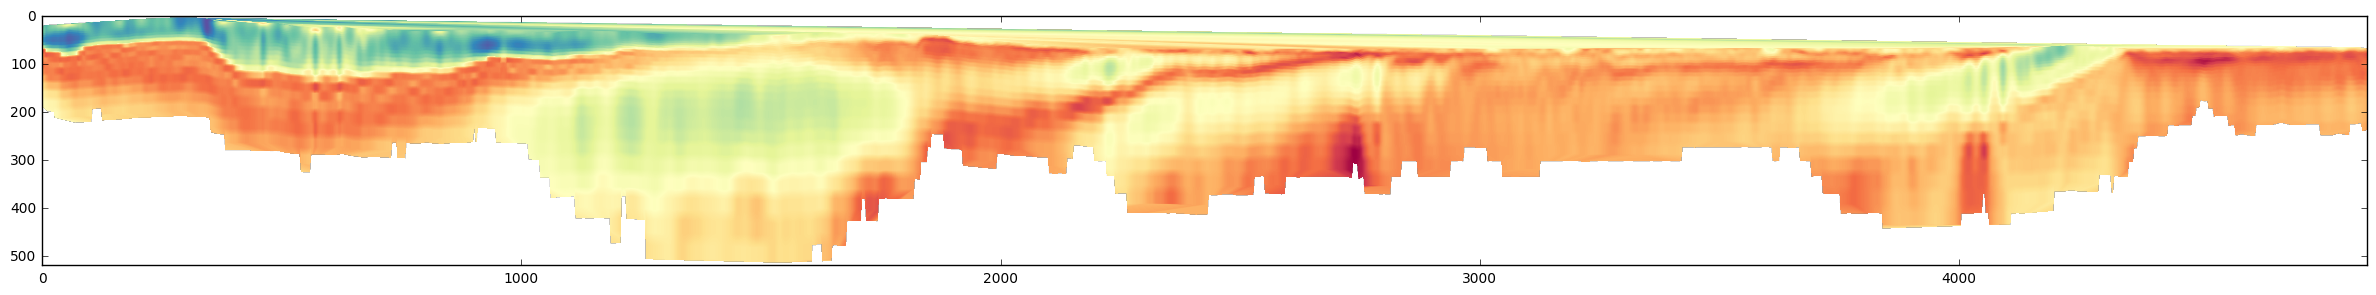

In [34]:
# Plot logarithmic colour stretch (linear stretch on log values)
plt.figure(figsize=(30,20))    
plt.imshow(np.log(conductivity_grid), cmap='Spectral_r')